# Analiza prometnih nesreća u SAD

# Treniranje i evaulacija

# Import i priprema


In [10]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Učitavanje i razdvajanje skupa


In [11]:
df = pd.read_csv("nesrece_model_podaci.csv")

# X: feature-i, y: ciljna varijabla
X = df.drop(columns=['accident_count'])
y = df['accident_count']


# One-hot encoding i pipeline


In [12]:
categorical = ['Weather_Condition']
numerical = ['Lat_Group', 'Lng_Group', 'Hour', 'Month']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder='passthrough' 
)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1))
])


# Treniranje i evaulacija


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time.time()
model.fit(X_train, y_train)
end = time.time()

print(f"Trening završen za {end - start:.2f} sekundi")

# Predikcija
y_pred = model.predict(X_test)

# Evaluacija
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

Trening završen za 461.88 sekundi
RMSE: 14.50
R2 Score: 0.92


# Vizualna evaluacija


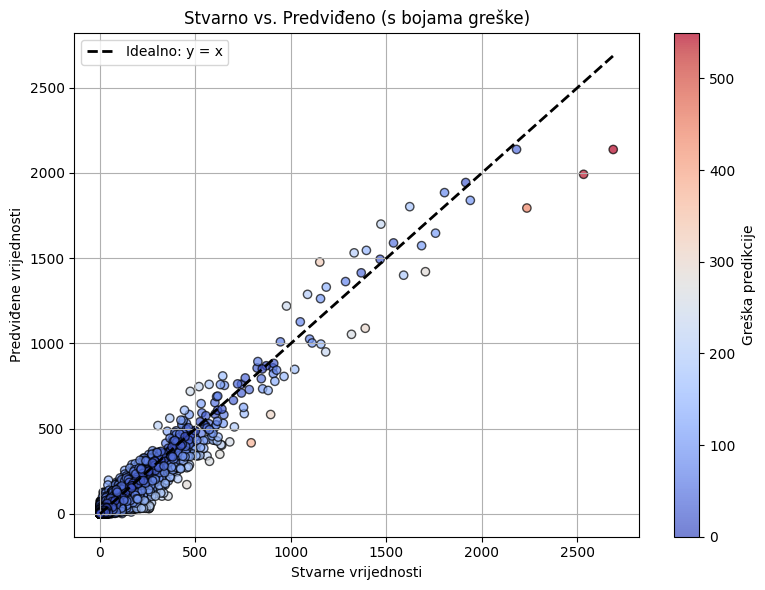

In [14]:
# Scatter plot sa bojom greške i dijagonalom
greske = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c=greske, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Idealno: y = x")
plt.colorbar(label='Greška predikcije')
plt.xlabel("Stvarne vrijednosti")
plt.ylabel("Predviđene vrijednosti")
plt.title("Stvarno vs. Predviđeno (s bojama greške)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Histogram grešaka (residuala)


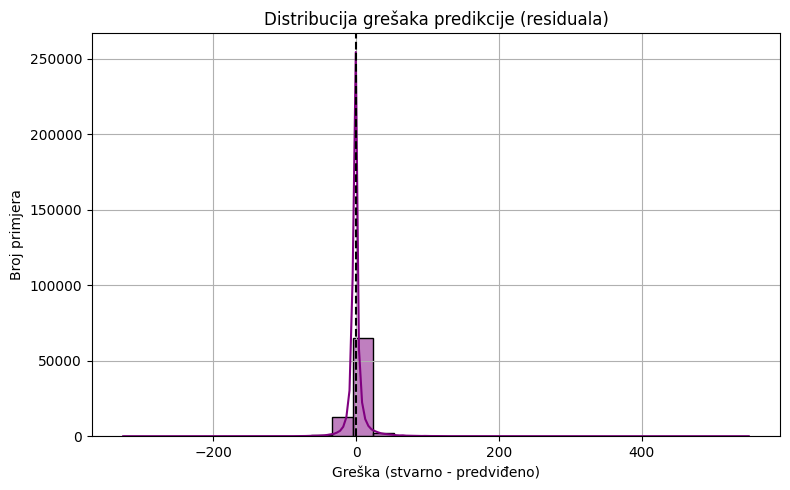

In [15]:
residuali = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuali, bins=30, kde=True, color='purple')
plt.axvline(0, color='black', linestyle='--')
plt.title("Distribucija grešaka predikcije (residuala)")
plt.xlabel("Greška (stvarno - predviđeno)")
plt.ylabel("Broj primjera")
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature importance


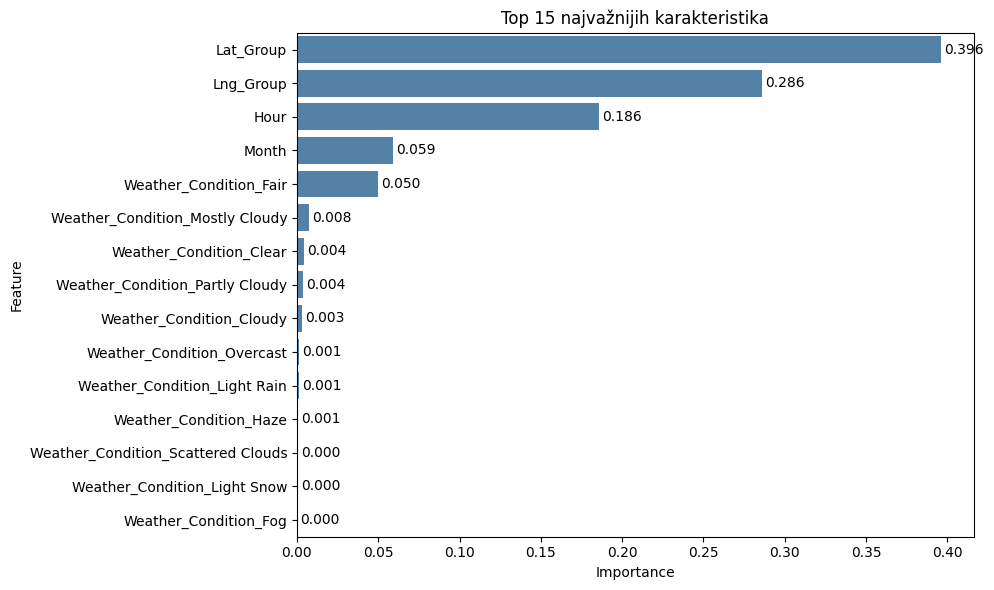

In [16]:
# Izdvajanje imena feature-a
ohe = model.named_steps['preprocess'].named_transformers_['cat']
feature_names = list(ohe.get_feature_names_out(['Weather_Condition']))
feature_names += ['Lat_Group', 'Lng_Group', 'Hour', 'Month']

# Dobijanje važnosti
importances = model.named_steps['regressor'].feature_importances_

# Priprema DataFrame-a
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Prikaz samo top N najvažnijih zbog preglednosti
top_n = 15
top_feat_df = feat_df.head(top_n)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_feat_df, x='Importance', y='Feature', color='steelblue')
plt.title("Top 15 najvažnijih karakteristika")

for i, v in enumerate(top_feat_df["Importance"]):
    ax.text(v + 0.002, i, f"{v:.3f}", color='black', va='center')

plt.tight_layout()
plt.show()



# Funkcija za predikciju


In [17]:


def predict_risk(lat_group, lng_group, hour, month, weather):
    sample = pd.DataFrame([{
        'Lat_Group': lat_group,
        'Lng_Group': lng_group,
        'Hour': hour,
        'Month': month,
        'Weather_Condition': weather
    }])
    return model.predict(sample)[0]


# Primjer poziva


In [18]:


rezultat = predict_risk(lat_group=10, lng_group=8, hour=7, month=1, weather='Rain')
print(f"Predikcija broja nesreća: {rezultat:.2f}")


Predikcija broja nesreća: 2.79
